In [1]:
import os
import functools
import operator
import concurrent.futures

In [2]:
import h5py
import numpy as np
from scipy import stats
import matplotlib as mpl
import matplotlib.pyplot as plt
import smatch
import healsparse

In [3]:
import lib

In [4]:
def get_weight(weight_dataset, weight_keys=["statistical_weight"]):
    return functools.reduce(
        operator.mul,
        [
            weight_dataset[weight_key][:]
            for weight_key in weight_keys
        ],
    )

In [5]:
os.environ["IMSIM_DATA"] = "/global/cfs/cdirs/desbalro"
os.environ["MEDS_DIR"] = "/global/cfs/cdirs/desbalro"

In [6]:
lib.plotting.setup()

In [7]:
onecolumn_kwargs = {
    "width": 2,
    "height": 2,
    "horizontal_margin": 8/12,
    "vertical_margin": 6/12,
    "gutter": 1,
    "fig_width": 3 + 4/12,
    "fig_height": 3,
}
twocolumn_kwargs = {
    "width": 6,
    "height": 2,
    "margin": 1,
    "gutter": 1,
    "fig_width": 8,
    "fig_height": 4,
}

In [8]:
shear_step_plus = "g1_slice=0.02__g2_slice=0.00__g1_other=0.00__g2_other=0.00__zlow=0.0__zhigh=6.0"
shear_step_minus = "g1_slice=-0.02__g2_slice=0.00__g1_other=0.00__g2_other=0.00__zlow=0.0__zhigh=6.0"

assert shear_step_plus in lib.const.SHEAR_STEPS
assert shear_step_minus in lib.const.SHEAR_STEPS

In [9]:
with (
    h5py.File(lib.const.SIM_SHEAR_CATALOGS[shear_step_plus]) as shear_plus,
    h5py.File(lib.const.SIM_SHEAR_CATALOGS[shear_step_minus]) as shear_minus,
):
    tiles = np.intersect1d(
        shear_plus["mdet"]["noshear"]["tilename"][:],
        shear_minus["mdet"]["noshear"]["tilename"][:],
    )

In [10]:
mdet_mask = lib.util.load_mdet_mask()
mdet_area = mdet_mask.get_valid_area()

# Clustering

In [11]:
def accumulate_y6_area(tile, mdet_mask):
    tile_area = lib.util.get_tile_area(
        tile,
        "r",
        shear=None,
        mdet_mask=mdet_mask,
        border=False,
    )

    return tile_area

In [12]:
def accumulate_sim_area(tile, mdet_mask, shear=None):
    tile_area = lib.util.get_tile_area(
        tile,
        "r",
        shear=shear,
        mdet_mask=mdet_mask,
        border=True,
    )

    return tile_area

In [13]:
# _area_y6 = {}
_area_sim_plus = {}
_area_sim_minus = {}
with concurrent.futures.ThreadPoolExecutor(max_workers=8) as executor:
    for i, tile in enumerate(tiles):
        # _future = executor.submit(
        #     accumulate_y6_area,
        #     tile,
        #     mdet_mask,
        # )
        # _area_y6[tile] = _future

        _future = executor.submit(
            accumulate_sim_area,
            tile,
            mdet_mask,
            shear="plus",
        )
        _area_sim_plus[tile] = _future

        _future = executor.submit(
            accumulate_sim_area,
            tile,
            mdet_mask,
            shear="minus",
        )
        _area_sim_minus[tile] = _future

In [14]:
NBINS = 100 
# bins = np.deg2rad(np.geomspace(1e-2, 1e1, NBINS + 1) / 60)
bins = np.geomspace(1e-2, 2e0, NBINS + 1) * 60

In [16]:
hist_y6 = {}

with (
    h5py.File(f"/pscratch/sd/s/smau/fiducial-neighbors/neighbors_y6.hdf5") as neighbors,
    h5py.File(lib.const.Y6_TOMOGRAPHY_CATALOG) as tomography,
):
    neighbor_distance = np.rad2deg(neighbors["mdet"]["noshear"]["neighbor_distance"][:]) * 60 * 60
    bhat = tomography["sompz"]["noshear"]["bhat"][:]

    for tomographic_bin in lib.const.TOMOGRAPHIC_BINS:
        _sel = (bhat == tomographic_bin)
  
        _hist, _ = np.histogram(neighbor_distance[_sel], bins=bins)    
    
        hist_y6[tomographic_bin] = _hist / mdet_area

    del neighbor_distance, bhat

In [17]:
# _hist_y6 = {}

# with (
#     h5py.File(lib.const.Y6_SHEAR_CATALOG) as shear,
#     h5py.File(f"/pscratch/sd/s/smau/fiducial-neighbors/neighbors_y6.hdf5") as neighbors,
#     h5py.File(lib.const.Y6_TOMOGRAPHY_CATALOG) as tomography,
# ):
#     neighbor_distance = np.rad2deg(neighbors["mdet"]["noshear"]["neighbor_distance"][:]) * 60 * 60
#     tilename = shear["mdet"]["noshear"]["tilename"][:]
#     bhat = tomography["sompz"]["noshear"]["bhat"][:]

#     for tomographic_bin in lib.const.TOMOGRAPHIC_BINS:
#         _hist_y6[tomographic_bin] = {}
        
#         for tile in tiles:
#             in_tile = (tilename == tile)
#             in_tomo = (bhat == tomographic_bin)
#             _sel = (in_tile & in_tomo)
      
#             _hist, _ = np.histogram(neighbor_distance[_sel], bins=bins)    
        
#             _hist_y6[tomographic_bin][tile] = _hist

#     del neighbor_distance, tilename, bhat

In [18]:
def accumulate_hist(tilename, bhat, weight, neighbor_distance, bins, tomographic_bin, tile):
    in_tile = (tilename == tile)
    in_tomo = (bhat == tomographic_bin)
    sel = (in_tile & in_tomo)
    if weight is None:
        weight = np.ones(sel.shape)

    hist, _ = np.histogram(neighbor_distance[sel], bins=bins, weights=weight[sel])
    # if np.sum(weight[sel]) > 0:
    #     _w = weight[sel] / np.sum(weight[sel])
    #     hist, _, _ = stats.binned_statistic(neighbor_distance[sel], _w, statistic="sum", bins=bins)
    # else:
    #     hist = np.zeros(len(bins) - 1)

    return hist

In [40]:
_hist_sim = {}
_hist_sim_weighted = {}

with (
    h5py.File(lib.const.SIM_SHEAR_CATALOGS[shear_step_plus]) as shear,
    h5py.File(lib.const.SIM_TOMOGRAPHY_CATALOGS[shear_step_plus]) as tomo,
    h5py.File(lib.const.SIM_WEIGHT_CATALOGS[shear_step_plus]) as weight,
    h5py.File(f"/pscratch/sd/s/smau/fiducial-neighbors/neighbors_{shear_step_plus}.hdf5") as neighbors,
):
    tilename = shear["mdet"]["noshear"]["tilename"][:]
    bhat = tomo["sompz"]["noshear"]["bhat"][:]
    weight = get_weight(weight["mdet"]["noshear"], weight_keys=["neighbor_weight"])
    neighbor_distance = np.rad2deg(neighbors["mdet"]["noshear"]["neighbor_distance"][:]) * 60 * 60

    with concurrent.futures.ThreadPoolExecutor(max_workers=2) as executor:
        for tomographic_bin in lib.const.TOMOGRAPHIC_BINS:
            _hist_sim[tomographic_bin] = {}
            _hist_sim_weighted[tomographic_bin] = {}
            
            for tile in tiles:
                _future = executor.submit(
                    accumulate_hist,
                    tilename,
                    bhat,
                    None,
                    neighbor_distance,
                    bins,
                    tomographic_bin,
                    tile,
                )
                _hist_sim[tomographic_bin][tile] = _future
                
                _future = executor.submit(
                    accumulate_hist,
                    tilename,
                    bhat,
                    weight,
                    neighbor_distance,
                    bins,
                    tomographic_bin,
                    tile,
                )
                _hist_sim_weighted[tomographic_bin][tile] = _future

    del tilename, bhat, weight, neighbor_distance

In [41]:
# hist_y6 = {}
hist_sim = {}
hist_sim_weighted = {}

for tomographic_bin in lib.const.TOMOGRAPHIC_BINS:
    # _densities_y6 = np.array(
    #     [
    #         _hist_y6[tomographic_bin][tile].result() / _area_y6[tile].result()
    #         for tile in tiles
    #     ]
    # )
    # hist_y6[tomographic_bin] = np.mean(_densities, axis=0)
    
    _densities_sim = np.array(
        [
            _hist_sim[tomographic_bin][tile].result() / _area_sim_plus[tile].result()
            for tile in tiles
        ]
    )
    hist_sim[tomographic_bin] = np.mean(_densities_sim, axis=0)

    _densities_sim_weighted = np.array(
        [
            _hist_sim_weighted[tomographic_bin][tile].result() / _area_sim_plus[tile].result()
            for tile in tiles
        ]
    )
    hist_sim_weighted[tomographic_bin] = np.mean(_densities_sim_weighted, axis=0)

    # hist_sim[tomographic_bin] = np.mean(
    #     [
    #         _hist_sim[tomographic_bin][tile].result()
    #         for tile in tiles
    #     ],
    #     axis=0,
    # ) / np.mean(
    #     [
    #         _area[tile].result()
    #         for tile in tiles
    #     ],
    #     axis=0,
    # )

    # hist_sim_weighted[tomographic_bin] = np.mean(
    #     [
    #         _hist_sim_weighted[tomographic_bin][tile].result()
    #         for tile in tiles
    #     ],
    #     axis=0,
    # ) / np.mean(
    #     [
    #         _area[tile].result()
    #         for tile in tiles
    #     ],
    #     axis=0,
    # )

    # _hmean_weights = np.where(np.array([v.result() for v in _hist_sim[tomographic_bin].values()]) > 0, 1, np.nan)
    # hist_sim[tomographic_bin] = stats.hmean(
    #     np.array([
    #         hist_res.result() / area_res.result()
    #         for (hist_res, area_res)
    #         in zip(_hist_sim[tomographic_bin].values(), _area.values())
    #     ]),
    #     axis=0,
    #     weights=_hmean_weights,
    #     nan_policy="omit",
    # ) * np.isfinite(_hmean_weights).sum() / np.isnan(_hmean_weights).sum()

    # _hmean_weights_weighted = np.where(np.array([v.result() for v in _hist_sim_weighted[tomographic_bin].values()]) > 0, 1, np.nan)
    # hist_sim_weighted[tomographic_bin] = stats.hmean(
    #     np.array([
    #         hist_res.result() / area_res.result()
    #         for (hist_res, area_res)
    #         in zip(_hist_sim_weighted[tomographic_bin].values(), _area.values())
    #     ]),
    #     axis=0,
    #     weights=_hmean_weights_weighted,
    #     nan_policy="omit",
    # ) * np.isfinite(_hmean_weights_weighted).sum() / np.isnan(_hmean_weights_weighted).sum()


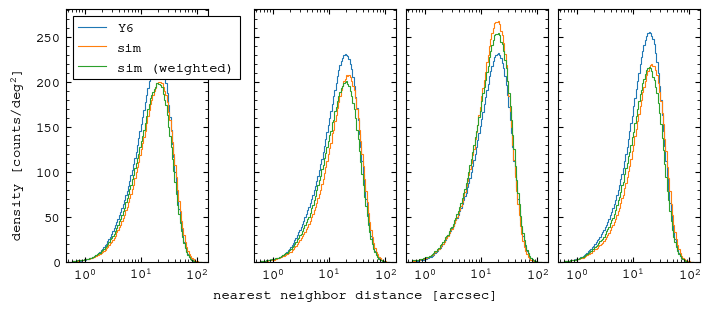

In [42]:
fig, axs = plt.subplots(1, len(lib.const.TOMOGRAPHIC_BINS), sharex=True, sharey=True, figsize=(7, 3), constrained_layout=True)

for i in lib.const.TOMOGRAPHIC_BINS:
    axs[i].stairs(
        hist_y6[i],
        edges=bins,
        label="Y6",
    )
    axs[i].stairs(
        hist_sim[i],
        edges=bins,
        label="sim",
    )
    axs[i].stairs(
        hist_sim_weighted[i],
        edges=bins,
        label="sim (weighted)",
    )


axs[0].set_xscale("log")
# plt.xlim(0, None)
axs[0].legend(loc="upper left")

fig.supxlabel("nearest neighbor distance [arcsec]")
fig.supylabel("density [$counts / deg^2$]")

plt.show()

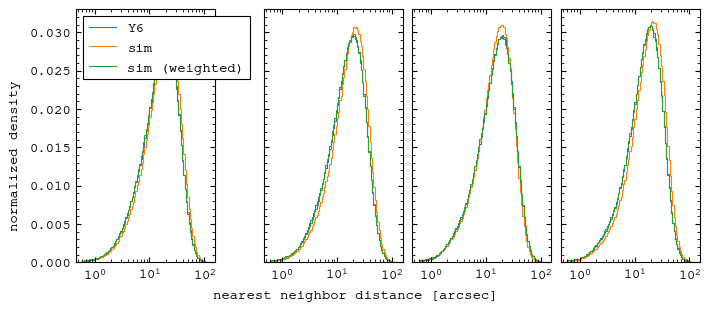

In [43]:
fig, axs = plt.subplots(1, len(lib.const.TOMOGRAPHIC_BINS), sharex=True, sharey=True, figsize=(7, 3), constrained_layout=True)

for i in lib.const.TOMOGRAPHIC_BINS:
    axs[i].stairs(
        hist_y6[i] / np.sum(hist_y6[i]),
        edges=bins,
        label="Y6",
    )
    axs[i].stairs(
        hist_sim[i] / np.sum(hist_sim[i]),
        edges=bins,
        label="sim",
    )
    axs[i].stairs(
        hist_sim_weighted[i] / np.sum(hist_sim_weighted[i]),
        edges=bins,
        label="sim (weighted)",
    )


axs[0].set_xscale("log")
# plt.xlim(0, None)
axs[0].legend(loc="upper left")

fig.supxlabel("nearest neighbor distance [arcsec]")
fig.supylabel("normalized density")

plt.show()

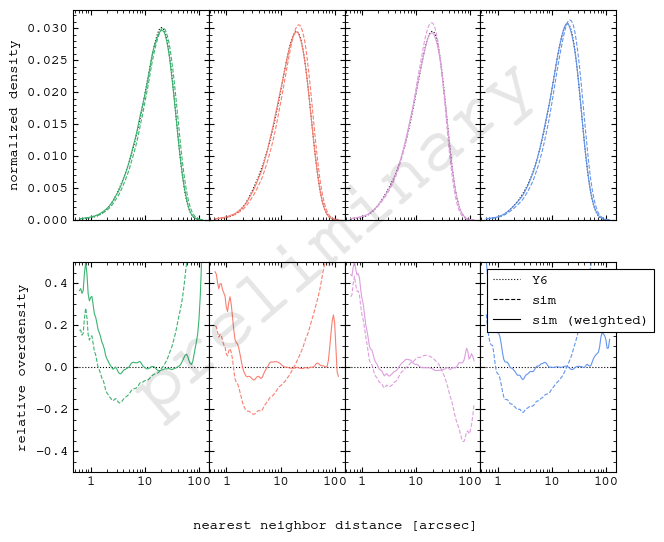

In [44]:
tomo_colors = {
    0: "#3BB470",
    1: "#FA7F72",
    2: "#DD9FDD",
    3: "#6495EC",
}

fig, axs = plt.subplots(
    2, len(lib.const.TOMOGRAPHIC_BINS),
    figsize=(7, 6),
    sharex=True,
    sharey="row",
)
fig.subplots_adjust(wspace=0)

for tomographic_bin in lib.const.TOMOGRAPHIC_BINS:
    lib.plotting.contour1d(
        axs[0, tomographic_bin],
        hist_y6[tomographic_bin] / np.sum(hist_y6[tomographic_bin]),
        bins,
        log=True,
        # c=tomo_colors[tomographic_bin],
        c="k",
        ls=":",
        label="Y6",
    )
    lib.plotting.contour1d(
        axs[0, tomographic_bin],
        hist_sim[tomographic_bin] / np.sum(hist_sim[tomographic_bin]),
        bins,
        log=True,
        c=tomo_colors[tomographic_bin],
        ls="--",
        label="sim",
    )
    lib.plotting.contour1d(
        axs[0, tomographic_bin],
        hist_sim_weighted[tomographic_bin] / np.sum(hist_sim_weighted[tomographic_bin]),
        bins,
        log=True,
        c=tomo_colors[tomographic_bin],
        ls="-",
        label="sim (weighted)",
    )

    axs[1, tomographic_bin].axhline(
        0,
        # c=tomo_colors[tomographic_bin],
        c="k",
        ls=":",
        # label="Y6",
    )
    lib.plotting.contour1d(
        axs[1, tomographic_bin],
        (hist_sim[tomographic_bin] / np.sum(hist_sim[tomographic_bin])) / (hist_y6[tomographic_bin] / np.sum(hist_y6[tomographic_bin])) - 1,
        bins,
        log=True,
        c=tomo_colors[tomographic_bin],
        ls="--",
        label="sim",
    )
    lib.plotting.contour1d(
        axs[1, tomographic_bin],
        (hist_sim_weighted[tomographic_bin] / np.sum(hist_sim_weighted[tomographic_bin])) / (hist_y6[tomographic_bin] / np.sum(hist_y6[tomographic_bin])) - 1,
        bins,
        log=True,
        c=tomo_colors[tomographic_bin],
        ls="-",
        label="sim (weighted)",
    )
    
# axs[0, 0].legend(loc="upper left")
# axs[1, 0].legend(loc="upper left")

axs[0, 0].set_xscale("log")
axs[0, 0].xaxis.set_major_formatter(mpl.ticker.ScalarFormatter())
axs[0, 0].set_ylim(0, None)

axs[1, 0].set_ylim(-0.5, 0.5)

fig.supxlabel("nearest neighbor distance [arcsec]")

# axs[0, 0].set_ylabel("density [$counts / deg^2$]")
axs[0, 0].set_ylabel("normalized density")
axs[1, 0].set_ylabel("relative overdensity")

lines = [
    mpl.lines.Line2D([0], [0], color="k", linestyle=ls)
    for ls in [":", "--", "-"]
]
labels = ["Y6", "sim", "sim (weighted)"]
axs[1, 3].legend(lines, labels, loc="upper left")

lib.plotting.watermark(fig)

# fig.savefig("tomographic-clustering.pdf")

plt.show()